In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.conv_ae_1D import *
import torch
import random
from torchvision.transforms import transforms as T, Lambda
from pathlib import Path
from config import *
from utils import *
from conv_utils import *


import numpy as np
import platform
import json

architecture='conv_ae1D'

In [36]:
exp_dict = exp_name_folders(path =esa_exploration, architecture=architecture)
for k in exp_dict.keys():
    print('num selection:{} - exp name:{}'.format(k, exp_dict[k]))

num selection:0 - exp name:4_wheel_system_02-09-23:14:38:56_conv_ae1D_sl_16_run3
num selection:1 - exp name:third_wheel_system_sl_40
num selection:2 - exp name:4_wheel_system_sl_40


In [37]:
select_exp = '0'
added_path = exp_dict[select_exp]
model_results_path = esa_exploration + '{}/{}'.format(architecture, added_path)
print('selected experiment:', added_path)

selected experiment: 4_wheel_system_02-09-23:14:38:56_conv_ae1D_sl_16_run3


In [38]:
files = os.listdir(model_results_path)
model_list, summary = find_models(files, model_results_path)

summary path: /home/roberto/Documents/backup_rob/repo/esa_fdir/time_series_anomaly_detection/model_results/esa_exploration/conv_ae1D/4_wheel_system_02-09-23:14:38:56_conv_ae1D_sl_16_run3/summary.csv


In [39]:
summary.reset_index().head()

,index,Unnamed: 0,name,parameters_number,train_loss,val_loss
0,39,6,"trainCONVAE1D_19e1d_00016_16_activation=Elu,ba...",113920,0.001774,0.000454
1,38,1,"trainCONVAE1D_19e1d_00012_12_activation=Elu,ba...",72960,0.001656,0.000495
2,37,30,"trainCONVAE1D_19e1d_00010_10_activation=Elu,ba...",72960,0.001656,0.000495
3,36,22,"trainCONVAE1D_19e1d_00026_26_activation=Elu,ba...",72960,0.001656,0.000498
4,35,3,"trainCONVAE1D_19e1d_00025_25_activation=Elu,ba...",113920,0.001717,0.000547


In [40]:
rank = 4
model_name_path = select_by_rank(rank, model_results_path, summary)
model_name = summary.name.iloc[rank]
f = open(os.path.join(model_results_path, '/'.join(model_name_path.split('/')[:-2]), 'params.json'))
print('hyper-parameters')
print(json.load(f))

hyper-parameters
{'activation': 'Elu', 'batch_size': 500, 'dilation': 1, 'epochs': 200, 'filter_num': 128, 'kernel_size': 9, 'lr': 0.0009, 'lr_patience': 5, 'n_layers': 1, 'pool': 'True', 'seq_in_length': 16}


In [41]:
try:
    sm = str(torch.cuda.get_device_capability())
    sm = ''.join((sm.strip('()').split(',')[0], sm.strip('()').split(',')[1])).replace(' ', '')
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda and sm in torch.cuda.get_arch_list() else "cpu")
except:
    device='cpu'

In [42]:
checkpoint  = torch.load(os.path.join(model_results_path, model_name_path), map_location=torch.device(device))
params_conf = checkpoint['param_conf']
cfg = checkpoint['cfg']

In [43]:
if 'flattened' in params_conf.keys():
    flattened = flattened=params_conf['flattened']
else:
    flattened=False
    
model = CONV_AE1D(in_channel=params_conf['in_channel'],  length=params_conf['length']
                  , kernel_size=params_conf['kernel_size'], filter_num=params_conf['filter_num'],
                 n_layers=params_conf['n_layers'], activation = params_conf['activation']
                  , stride=params_conf['stride'], pool=params_conf['pool'],
                  flattened=flattened).to(device).float()
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
par_nums = count_parameters(model)
print('number of params', par_nums)

Initializing conv2d weights with Kaiming He normal
Initializing conv2d weights with Kaiming He normal
CONV_AE1D(
  (act): ELU(alpha=1.0)
  (encoder): Encoder(
    (nn_enc): Sequential(
      (enc_lay_0): Sequential(
        (0): Conv1d(16, 128, kernel_size=(9,), stride=(1,), padding=(4,))
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ELU(alpha=1.0)
      )
      (enc_lay_1): Sequential(
        (0): Conv1d(128, 64, kernel_size=(9,), stride=(1,), padding=(4,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): ELU(alpha=1.0)
      )
    )
    (act): ELU(alpha=1.0)
  )
  (decoder): Decoder(
    (nn_dec): Sequential(
      (dec_lay_0): Sequential(
        (0): ConvTranspose1d(64, 128, kernel_size=(2,),

In [44]:
columns_subset=params_conf['columns_subset']
dataset_subset=params_conf['dataset_subset']
cols = cfg.dataset.columns
scaled = cfg.dataset.scaled
train_val_split = cfg.dataset.train_val_split
target = params_conf['target']
sequence_length = params_conf['sequence_length']
out_window = params_conf['sequence_length']
predict = params_conf['predict']

In [45]:
transform = T.Compose([
    T.ToTensor(),
    Lambda(lambda x: x.permute((0, 2, 1))),
    Lambda(lambda x: x.squeeze())
])
dataset_name = os.path.join(data_path.strip('..'), "all_2016-2018_clean_std_4s.pkl")
df_train, df_test, train_iter, test_iter = \
read_dataset_conv(dataset_name, cfg['dataset']['scaled'],cfg['dataset']['columns_subset']
                  , cfg['dataset']['dataset_subset'], cfg['dataset']['columns'], 
                 cfg['dataset']['train_val_split'], cfg['dataset']['sequence_length']
                  , cfg['dataset']['sequence_length'],  predict=False,
                 batch_size=4, transform=transform )

In [47]:
recon_loss=[]
batch_size=1000
for i, (x, y) in enumerate(test_iter):
    yo = model(x.to(device))
    #print(nn.MSELoss()(yo, y).item())
    recon_loss.append(nn.MSELoss()(yo, y).item())
print(np.mean(recon_loss))

KeyboardInterrupt: 

In [50]:
num_batch=5
print('time horizon {}'.format(num_batch*params_conf['sequence_length']))
x, shift = unrolling_batches_conv(num_batch, test_iter, sequence_length=params_conf['sequence_length']
                             , cols=cfg['dataset']['columns'], arch=architecture)

time horizon 80


In [51]:
yo = model(x.to(device))

In [52]:
seq_len = sequence_length
par_nums = count_parameters(model)

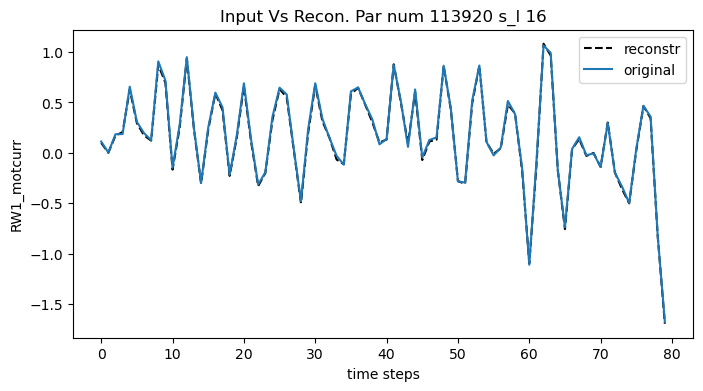

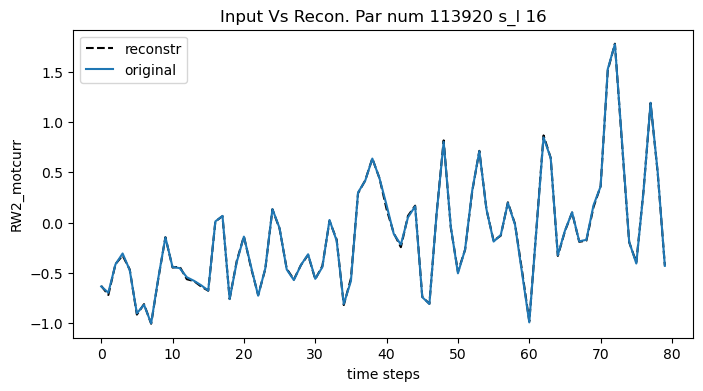

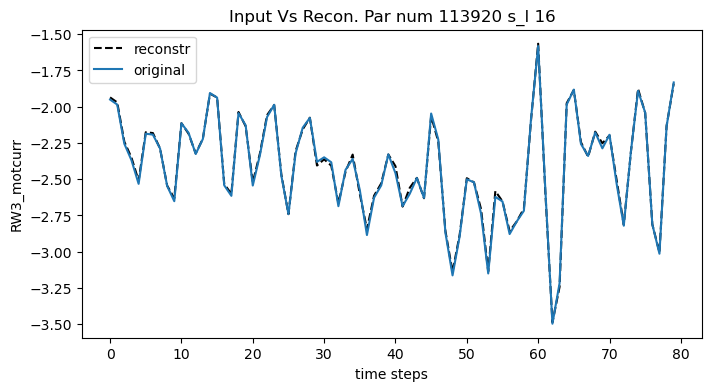

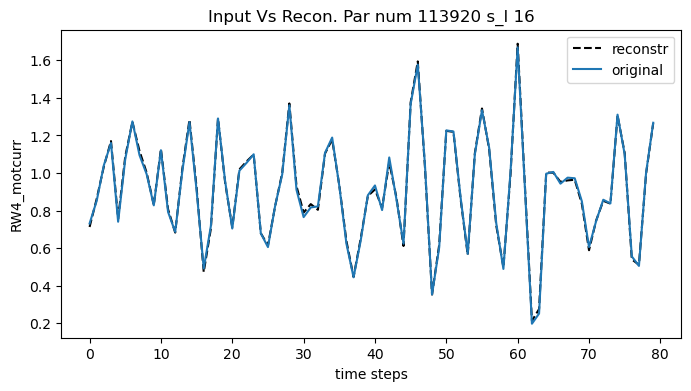

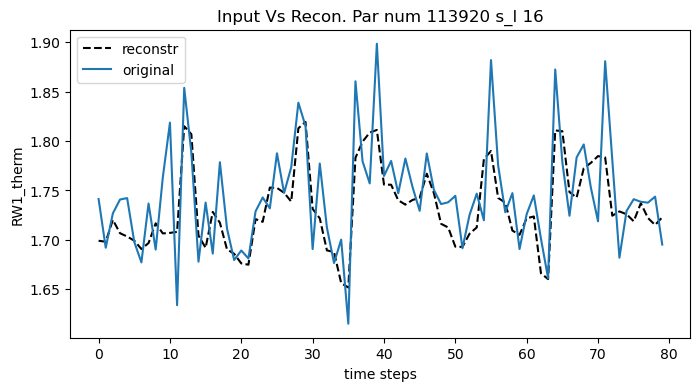

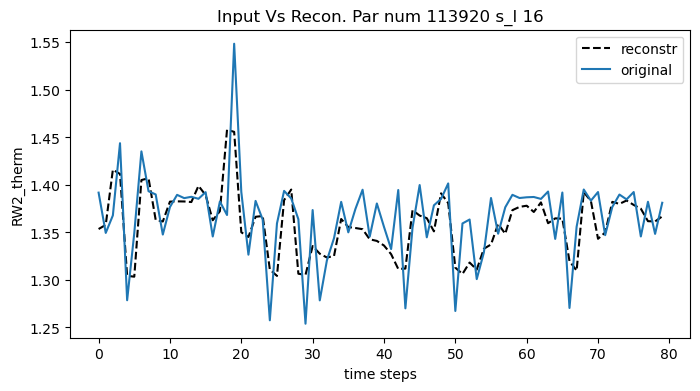

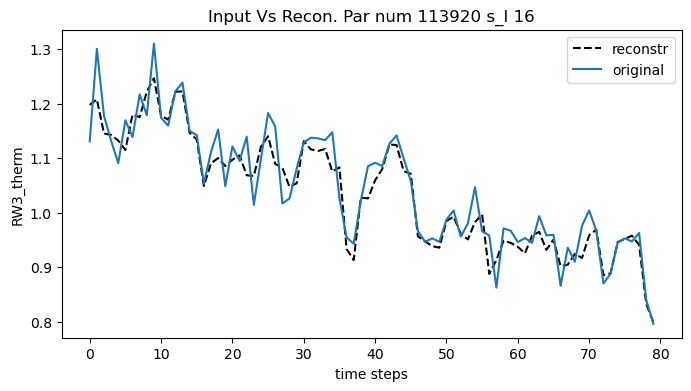

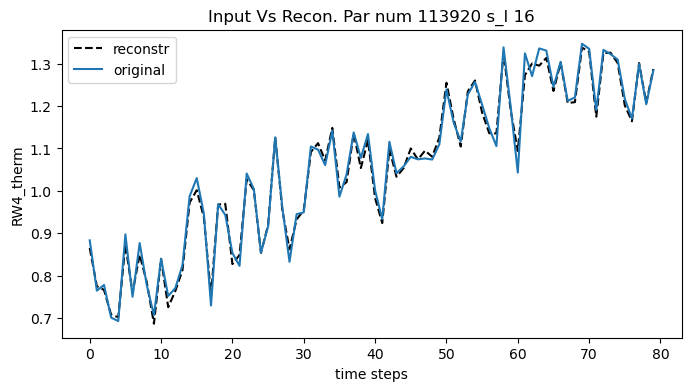

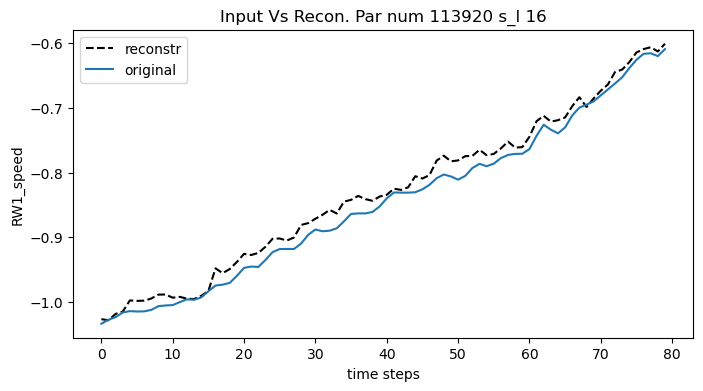

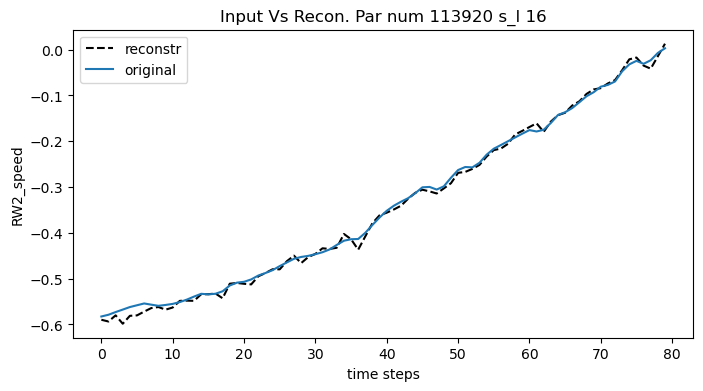

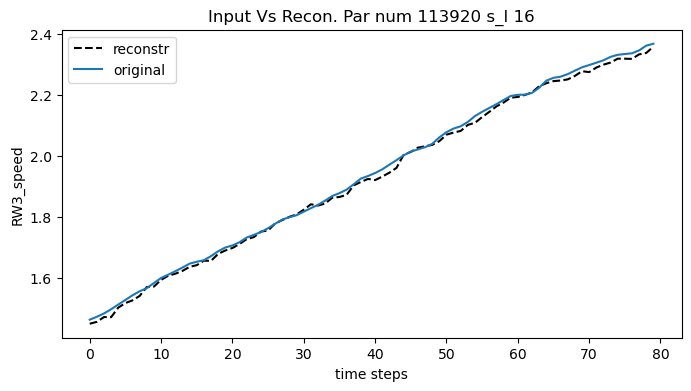

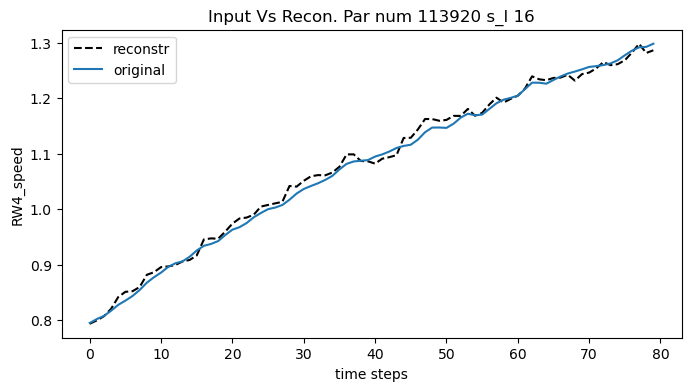

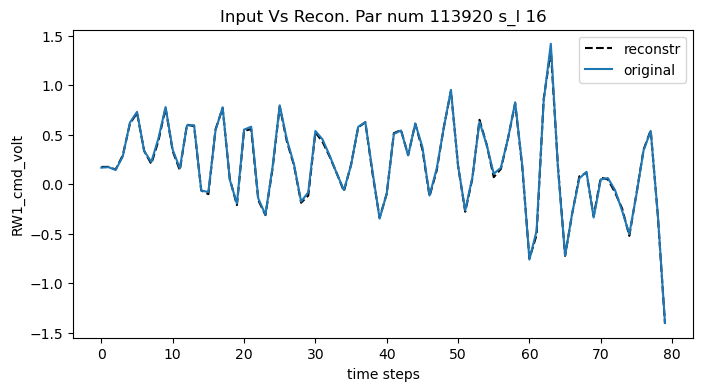

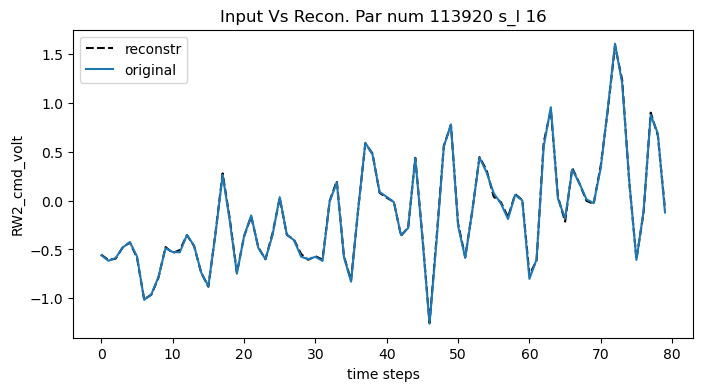

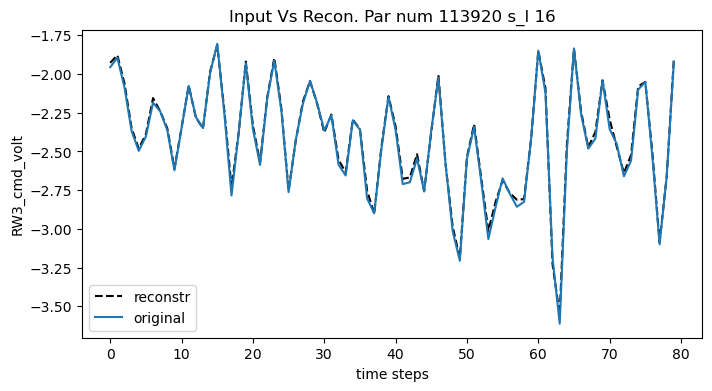

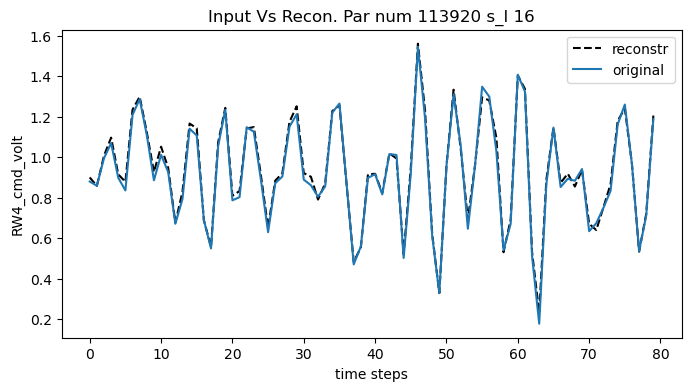

In [53]:
show_results(x, yo,cols,
    model_name, params_conf,
    par_nums, shift,num_batch,
    arch=architecture,
    save=False,)